# House Property Sales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

In [2]:
sales = pd.read_csv('raw_sales.csv')

In [3]:
sales.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [4]:
sales = sales.drop(['postcode','propertyType','bedrooms'], axis = 1)

In [5]:
sales.head()

,datesold,price
0,2007-02-07 00:00:00,525000
1,2007-02-27 00:00:00,290000
2,2007-03-07 00:00:00,328000
3,2007-03-09 00:00:00,380000
4,2007-03-21 00:00:00,310000


In [6]:
def dt(x): # x --> sales['datesold']
    return pd.to_datetime(x)

sales['datesold'] = sales['datesold'].apply(dt)

In [7]:
df = sales.set_index('datesold')

In [8]:
df.head()

,price
datesold,
2007-02-07,525000
2007-02-27,290000
2007-03-07,328000
2007-03-09,380000
2007-03-21,310000


In [9]:
print('The data Time range from {} to {}'.format(df.index.min(),df.index.max()))

The data Time range from 2007-02-07 00:00:00 to 2019-07-27 00:00:00


In [10]:
y = df['price'].resample('MS').mean()

In [11]:
y.head()

datesold
2007-02-01    407500.000000
2007-03-01    339333.333333
2007-04-01    798000.000000
2007-05-01    339500.000000
2007-06-01    520333.333333
Freq: MS, Name: price, dtype: float64

In [12]:
y.isna().sum()

0

# Exploratory Data Analysis

Text(0.5, 1.0, 'The Trend')

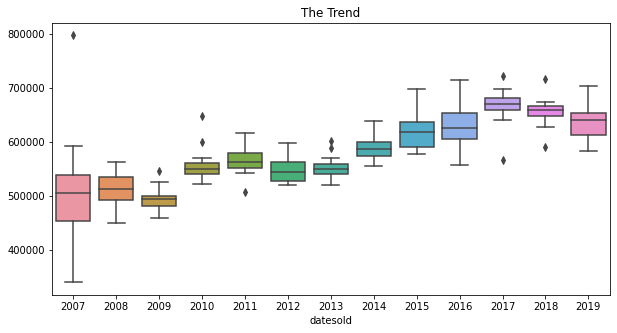

In [13]:
plt.figure(figsize = (10,5))
sns.boxplot(y = y.values, x = y.index.year)
plt.title('The Trend')

Text(0.5, 1.0, 'The Seasonality')

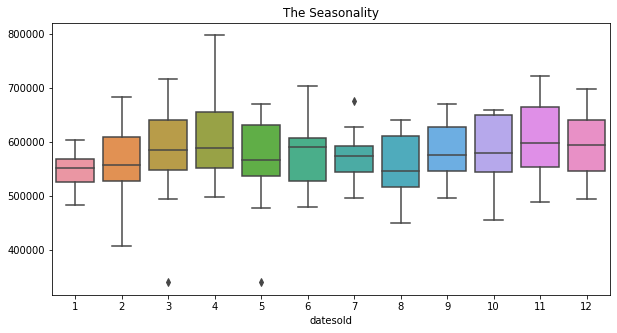

In [14]:
plt.figure(figsize = (10,5))
sns.boxplot(y = y.values, x = y.index.month)
plt.title('The Seasonality')

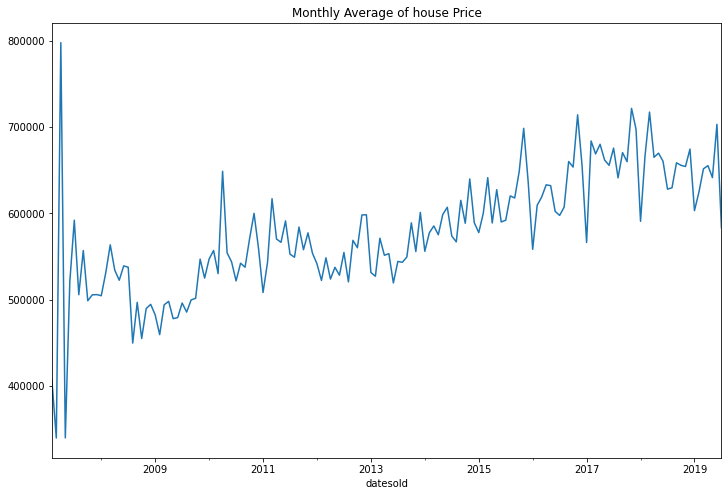

In [15]:
plt.figure(figsize = (12,8))
plt.title('Monthly Average of house Price')
y.plot()

> Dari plot di atas, sebenarnya sudah dapat dilihat bahwa plot ini tidaklah stationary. Namun untuk memastikannya, saya akan melakukan <i>Dickey Fuller test.</i>

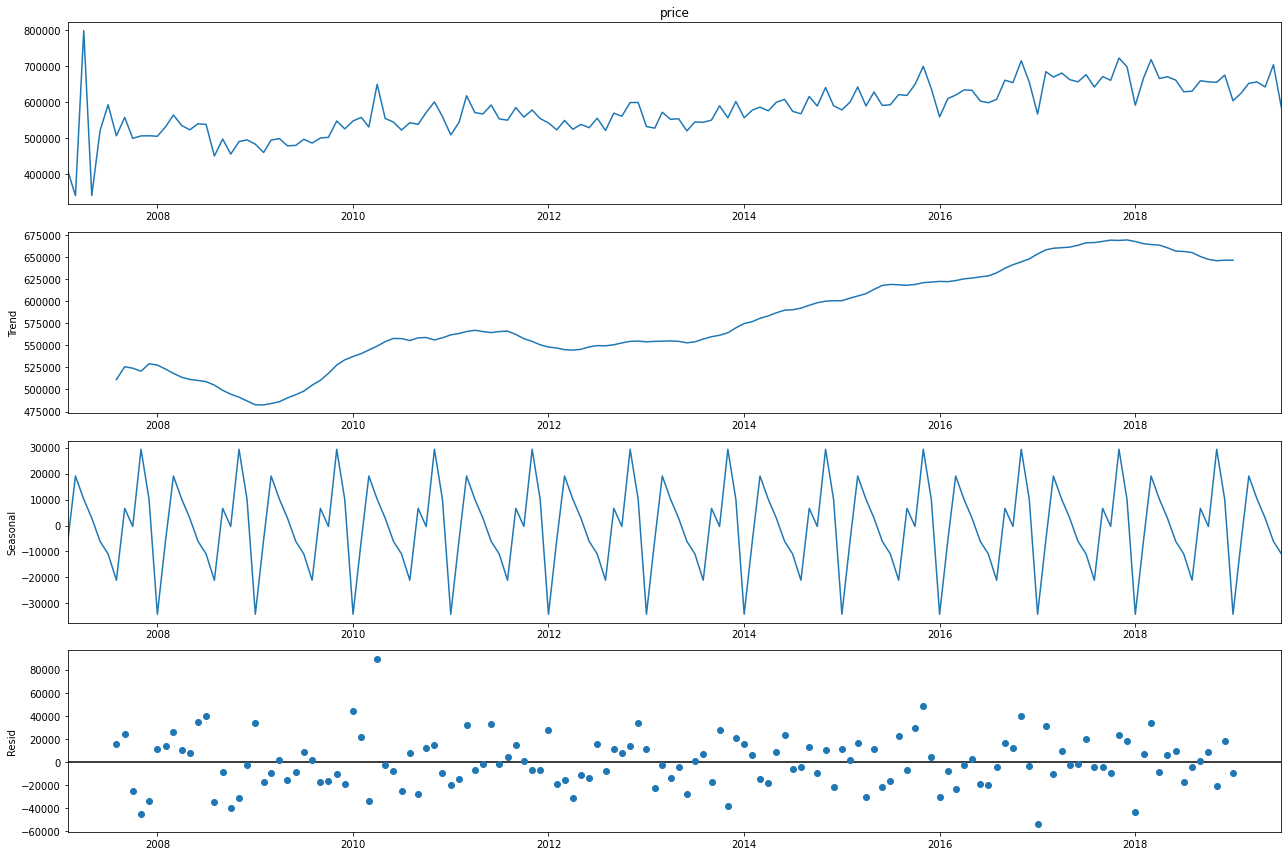

ADF Statistic:-0.6602138026458335
p-value: 0.8567877254659427


In [16]:
rcParams['figure.figsize'] = 18, 12
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

result = adfuller(y)
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

> Terlihat bahwa time-series ini tidaklah stationary.

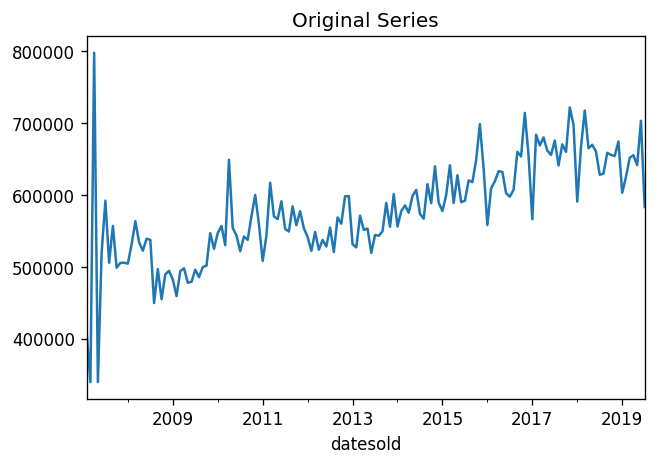

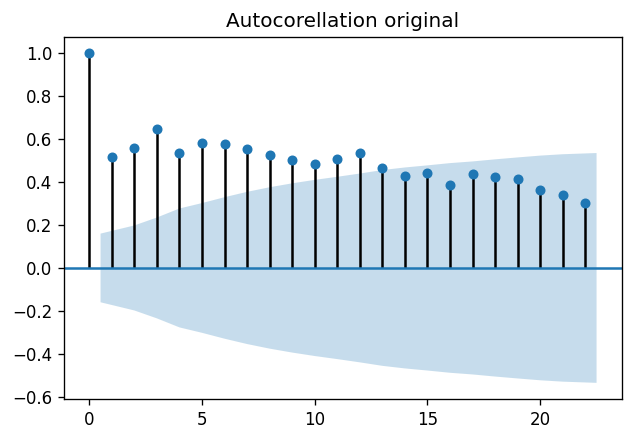

In [17]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

ori = y.plot()
ori.set_title('Original Series')
plot_acf(y, title = 'Autocorellation original')

plt.show()

> Dari plot di atas, terlihat bahwa lag yang besar pun masih memiliki korelasi yang signifikan

## Making a time series Stationary

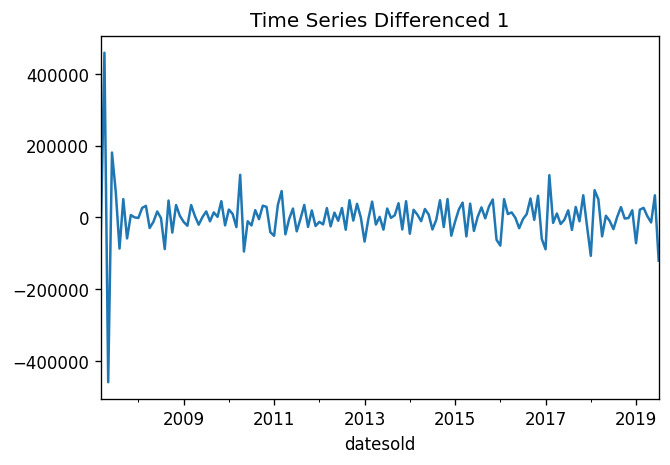

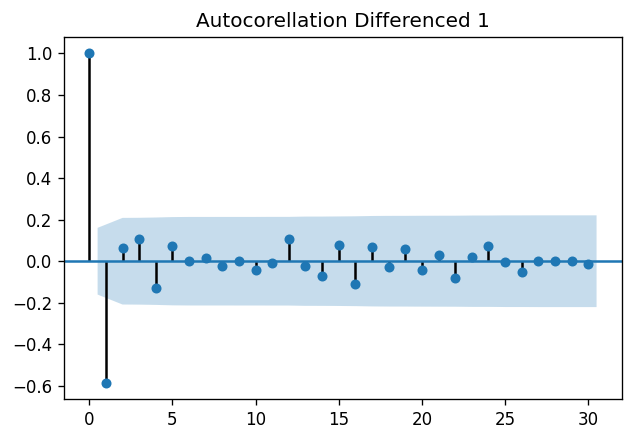

ADF Statistic:-5.3037712186114785
p-value: 5.378016232766266e-06


In [18]:
diff1 = y.diff().dropna().plot()
diff1.set_title('Time Series Differenced 1')
plot_acf(y.diff(1).dropna(),lags =30,  title = 'Autocorellation Differenced 1')

plt.show()

result = adfuller(y.diff().dropna())
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

Sekarang lebih baik

In [19]:
y_difference_1 = y.diff().dropna()

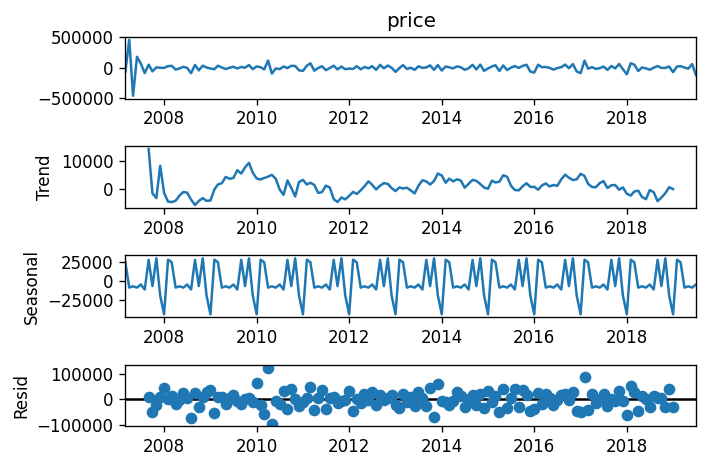

In [20]:
decomposition_difference_1 = sm.tsa.seasonal_decompose(y_difference_1, model='additive') 
fig = decomposition_difference_1.plot()
plt.show()

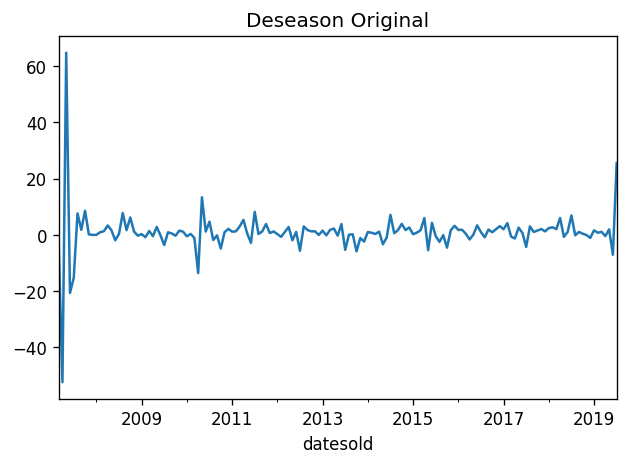

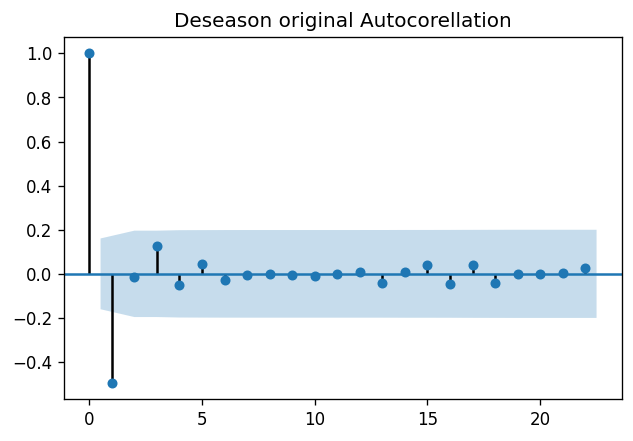

ADF Statistic:-20.803589107447092
p-value: 0.0


In [21]:
y_deseason = y_difference_1/ decomposition_difference_1.seasonal

ori_deseason = y_deseason.plot()
ori_deseason.set_title('Deseason Original')
plot_acf(y_deseason, title = 'Deseason original Autocorellation')

plt.show()

result = adfuller(y_deseason)
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

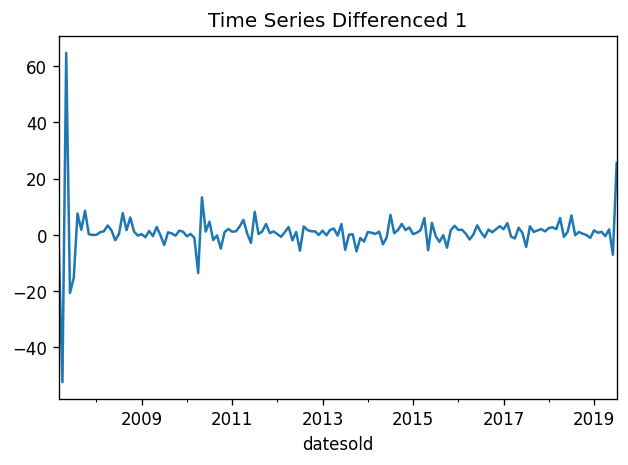

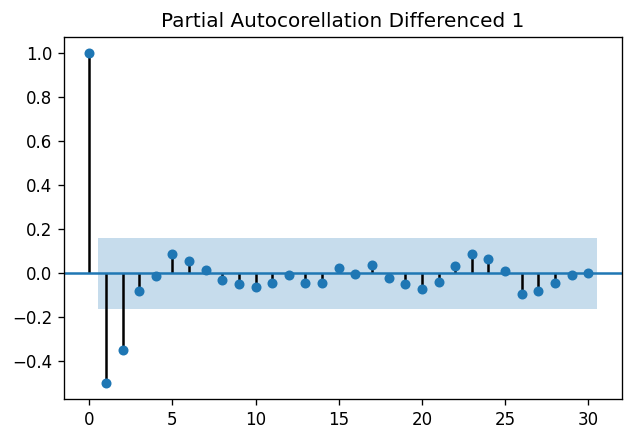

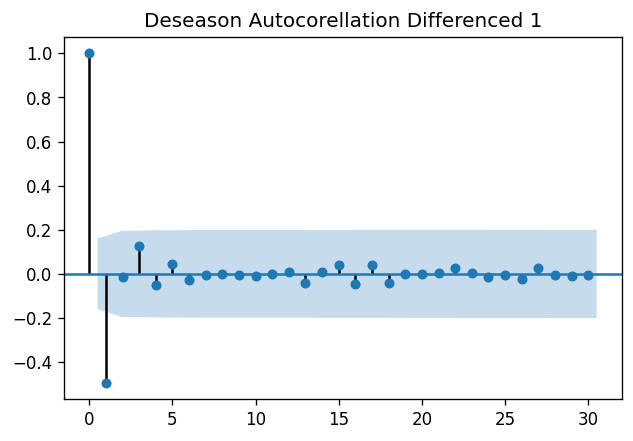

ADF Statistic:-20.803589107447092
p-value: 0.0


In [22]:
diff1 = y_deseason.plot()
diff1.set_title('Time Series Differenced 1')
plot_pacf(y_deseason, lags = 30, title = 'Partial Autocorellation Differenced 1')
plot_acf(y_deseason,lags = 30, title = 'Deseason Autocorellation Differenced 1')


plt.show()

result = adfuller(y_deseason)
print('ADF Statistic:{}'.format(result[0]))
print('p-value: {}'.format(result[1]))

#  ARIMA Model

## Manual ARIMA

Dari plot autocorrelation dan partial autocorrelation di atas terlihat bahwa p = 1, q = 1

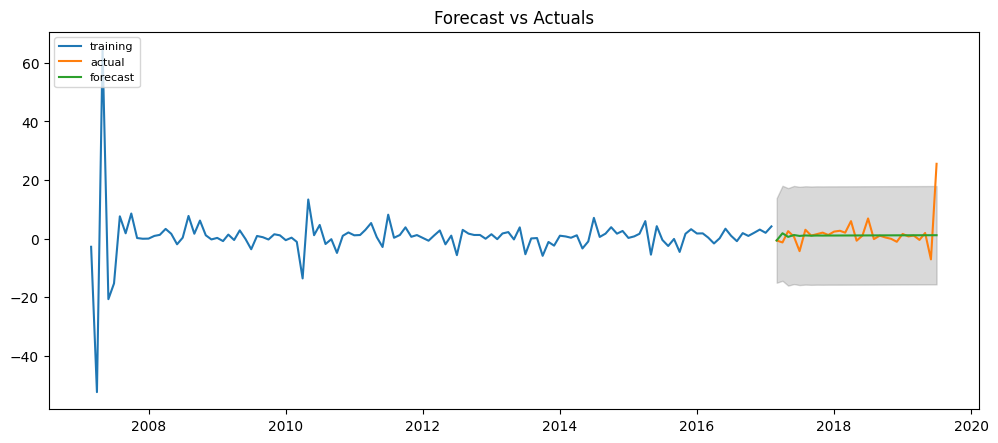

MAPE : 2.0014347016464153


In [23]:
train = y_deseason[:120]
test = y_deseason[120:]

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

fc, se, conf = fitted.forecast(29, alpha=0.05)  

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

print('MAPE : {}'.format(np.mean(np.abs(fc - test)/np.abs(test))))

## Auto ARIMA

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=981.544, BIC=993.560, Time=0.613 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=1047.912, BIC=1053.920, Time=0.032 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=1005.074, BIC=1014.086, Time=0.117 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=983.897, BIC=992.909, Time=0.189 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=1047.754, BIC=1050.758, Time=0.017 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=961.276, BIC=976.296, Time=0.340 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=960.383, BIC=972.399, Time=0.249 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=961.485, BIC=976.505, Time=0.429 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=962.667, BIC=980.690, Time=0.961 seconds
Total fit time: 3.020 seconds
                               SARIMAX Results                                
Dep. Variable:                 

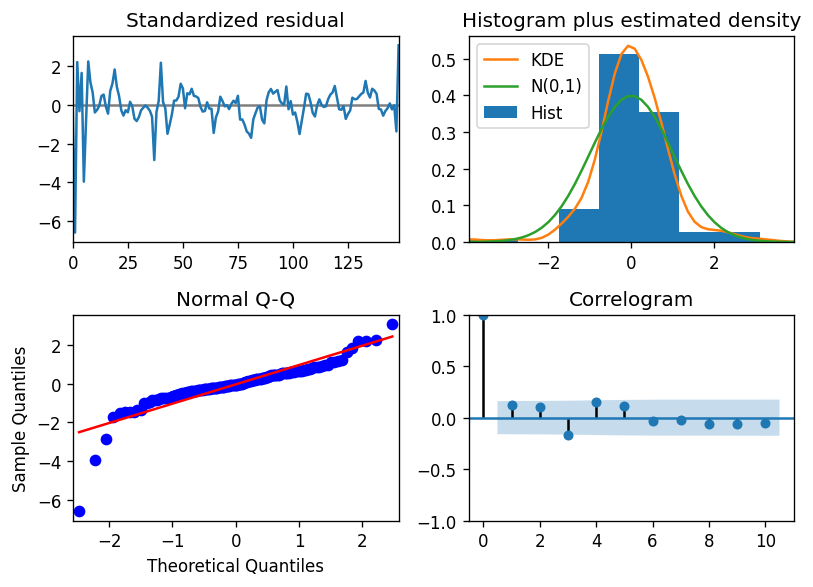

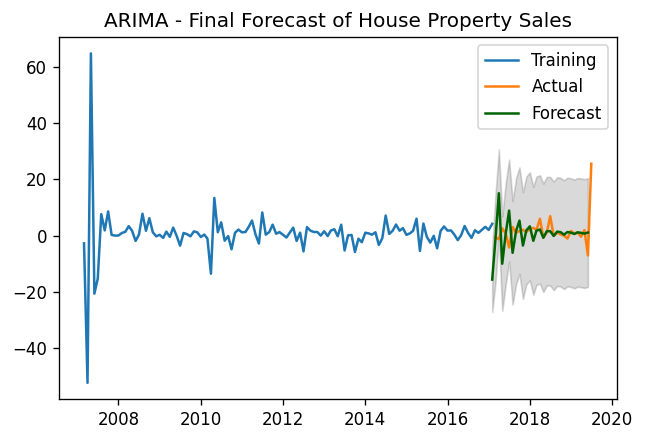

MAPE : 4.1676040493870605


In [24]:
train = y_deseason[:120]
test = y_deseason[120:]

model = pm.auto_arima(y_deseason, start_p=1, start_q=1, test='adf', max_p= 4, max_q=4, 
                      m=1, d=None, seasonal=False,   
                      start_P=0, D=0, trace=True,
                      error_action='ignore', 
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.tight_layout()
plt.show()

fitted, confint = model.predict(n_periods= 29, return_conf_int=True) 
index_of_fc = pd.date_range(train.index[-1], periods = 29, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.plot(train, label ='Training')
plt.plot(test, label = 'Actual')
plt.plot(fitted_series, color='darkgreen', label ='Forecast')
plt.legend()
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("ARIMA - Final Forecast of House Property Sales")
plt.show()

print('MAPE : {}'.format(np.mean(np.abs(fitted - test)/np.abs(test))))

> Performance keduanya masih sama buruknya.

# SARIMA Model

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=3461.282, BIC=3467.122, Time=0.092 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=3358.479, BIC=3370.159, Time=0.886 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=3357.164, BIC=3368.844, Time=0.887 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=3459.901, BIC=3462.821, Time=0.048 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=3523.370, BIC=3532.130, Time=0.297 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=3358.810, BIC=3373.410, Time=1.720 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=3358.537, BIC=3373.137, Time=2.832 seconds
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=3408.260, BIC=3419.940, Time=1.800 seconds
Fit ARIMA(0,1,1)x(1,1,2,12) [intercept=True]; AIC=3356.160, BIC=3373.680, Time=5.181 seconds
Fit ARIMA(0,1,1)x(2,1,2,12) [intercept=True]; AIC=3352.420, BIC=3372.860, Time=7.510 seconds
Fit ARIMA(0,1,1)x(2,1,1,12

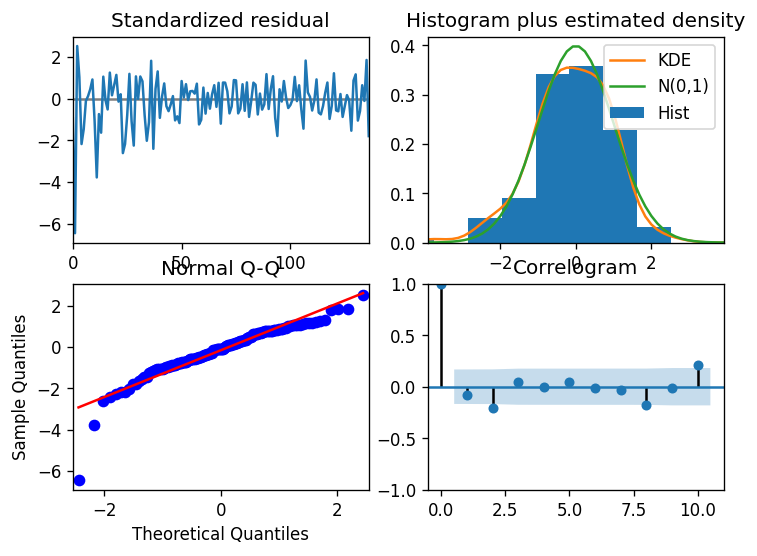

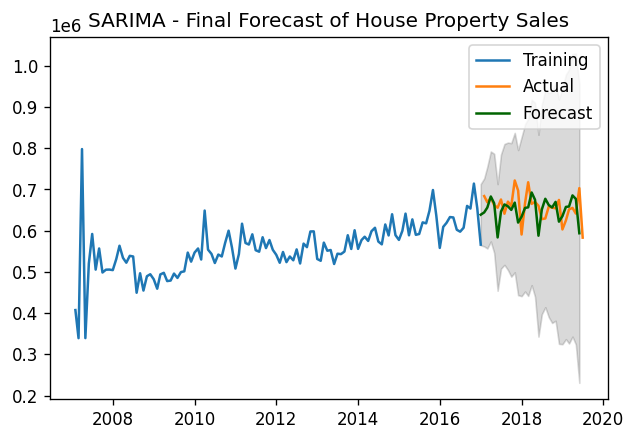

MAPE : 0.0356702047506499


In [25]:
model = pm.auto_arima(y, start_p=0, start_q=0, test='adf', max_p=5, max_q=5, 
                      m=12, d=None, seasonal=True, start_P=0, start_Q = 0, 
                      D=1, trace=True, error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.show()

train = y[:120]
test = y[120:]

fitted, confint = model.predict(n_periods= 30, return_conf_int=True) 
index_of_fc = pd.date_range(train.index[-1], periods = 30, freq='MS')

fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.plot(train, label ='Training')
plt.plot(test, label = 'Actual')
plt.plot(fitted_series, color='darkgreen', label ='Forecast')
plt.legend()
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of House Property Sales")
plt.show()

print('MAPE : {}'.format(np.mean(np.abs(fitted - test)/np.abs(test))))

* Residual terlihat mengikuti distribusi normal dan tidak memiliki korelasi yang signifikan. Namun seharusnya bisa leibh baik lagi melihat model sedikit bias.
* MAPE hanya 3% yang menandakan akurasi yang tinggi

# Conclusion

SARIMA model yang lebih baik dari ARIMA dalam menangani hal ini. Itu kenapa seasonal faktor tidak dapat dihiraukan pada penjualan properti rumah.